In [1]:
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import random

## Importing Test and Train Data

In [2]:
n_train = 60000
n_test = 10000

f = open('t10k-images.idx3-ubyte','rb')
image_size = 28
num_images = 10000
t = f.read(16)
buf = f.read(image_size * image_size * num_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(num_images, image_size*image_size)

f = open('train-images.idx3-ubyte','rb')
image_size = 28
num_images = 60000
t = f.read(16)
buf = f.read(image_size * image_size * num_images)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(num_images, image_size*image_size)

f = open('t10k-labels.idx1-ubyte','rb')
num_images = 10000
t = f.read(8)
buf = f.read(num_images)
test_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
temp = np.zeros((num_images,), dtype = np.int8)
for index,i in enumerate(test_labels):
    if test_labels[index]>4:
        temp[index] = 1
test_labels = temp

f = open('train-labels.idx1-ubyte','rb')
num_images = 60000
t = f.read(8)
buf = f.read(num_images)
train_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
temp = np.zeros((num_images,), dtype = np.int8)
for index,i in enumerate(train_labels):
    if train_labels[index]>4:
        temp[index] = 1
train_labels = temp



## Q1 - Normalization

In [5]:
#normalize function
def normalize(data):
    means = np.mean(data, axis=1)
    stds = np.std(data, axis = 1)
    #print(stds)
    norm_data = []
    for i in range(len(data)):
        temp = (data[i] - means[i])/stds[i]
        temp = np.append(temp,1)
        norm_data.append(temp)
    return np.array(norm_data)
        

In [6]:
test_norm = normalize(test_data)
train_norm = normalize(train_data)

## Q2 - Linear Classifier with Quadratic Loss

In [26]:
#testing function to check classification accuracy
def tester(datax,datay,v):
    pred = v@datax.T

    #pred = [sigmoid(i) for i in pred]
    pred = [1 if i>0.5 else 0 for i in pred]
    c = 0
    for x,y in zip(pred, datay):
        if x==y: c+=1
    return c/len(pred)

In [27]:
d=785  # Input dimension.
n=0.001  #learning rate
b=10
itrs = 60000
v=np.random.normal(loc=0.0, scale=(1/d)**0.5, size=(d,))# Output layer
#v=np.zeros((d,))
iteration_counter =[]
test_acc = []
train_acc = []

for i in tqdm(range(itrs+1)):
    cur_batch = np.random.randint(0, high = 60000, size = b)     #picking random images from entire dataset
    x = train_norm[cur_batch]
    y = train_labels[cur_batch]
    temp = x@v - y
    G = x.T@temp
    G = G/b
    v = v - n*G
    
    #checking accuracy
    if i%600==0:
        l = tester(test_norm, test_labels, v.T)
        test_acc.append(l)
        iteration_counter.append(i)
        l1 = tester(train_norm, train_labels, v.T)
        train_acc.append(l1)
        
v=v.T
print("Test Accuracy = "+str(100*tester(test_norm, test_labels, v.T))+"%")

100%|███████████████████████████████████| 60001/60001 [00:13<00:00, 4323.65it/s]

Test Accuracy = 86.04%


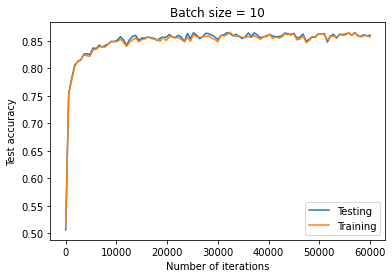

In [28]:
#plot of accuracy vs number of iterations

plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Batch size = "+str(b))
leg = plt.legend()
plt.show()

## Q3 - Neural Network with Quadratic Loss

In [32]:
#required functions
def relu(x):
    return np.maximum(x,0)

def predict(w,U,x):
    return sigmoid(w.dot(relu(U.dot(x))))

def loss(w,U,Y,X):
    return npl.norm(Y-predict(w,U,X))**2

def forward(x,w,v):
    l1 = w@x
    l1_func = relu(l1)
    l2 = l1_func@v
    return l1, l1_func, l2   

#testing function
def tester_neural(datax,datay,w,v):
    pred = []
    for x,y in zip(datax, datay):
        l1,l1_f,l2 = forward(x,w,v)
        pred.append(l2)
        
    pred = [1 if i>0.5 else 0 for i in pred]
    c = 0
    for x,y in zip(pred, datay):
        if x==y: c+=1
    return c/len(pred)

In [37]:
# My neural network trained using SGD
k=200  # Number of hidden units
d=785  # Input dimension
n=0.1  #learning rate
b=10
itrs = 60000
#xavier initialization
w=np.random.normal(loc=0.0, scale=(1/d)**0.5, size=(k,d))# Input layer  
v=np.random.normal(loc=0.0, scale=(1/k)**0.5, size=(k,))# Output layer  
#w = np.zeros((k,d))
#v=np.zeros((k,))
iteration_counter =[]
test_acc = []
train_acc = []

for i in tqdm(range(itrs+1)):
    cur_batch = np.random.randint(0, high = 60000, size = b)     #picking random images from entire dataset
    xdata = train_norm[cur_batch]
    ydata = train_labels[cur_batch]
    gw =0
    gv =0
    for x,y in zip(xdata, ydata):
        l1,l1_f,l2 = forward(x,w,v)
        gv+=(l2 - y)*(l1_f)
        relu_der = np.heaviside(l1,0)
        temp = v*relu_der
        gw+= (l2 - y)*(temp.reshape((k,1))@x.reshape((1,785)))
    
    #checking accuracy
    if i%1000==0:
        l = tester_neural(test_norm, test_labels, w, v)
        test_acc.append(l)
        iteration_counter.append(i)
        l1 = tester_neural(train_norm, train_labels, w, v)
        train_acc.append(l1)
    
    v-=(n/b)*gv
    w-=(n/b)*gw
    

100%|█████████████████████████████████████| 60001/60001 [10:40<00:00, 93.73it/s]


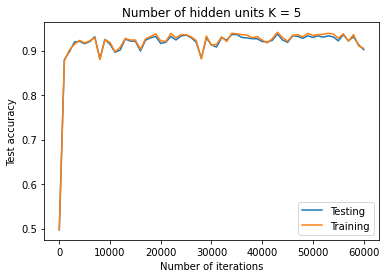

Accuracy = 92.5%


In [36]:
plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Number of hidden units K = "+str(k))
leg = plt.legend()
plt.show()
accuracy = tester_neural(test_norm,test_labels,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

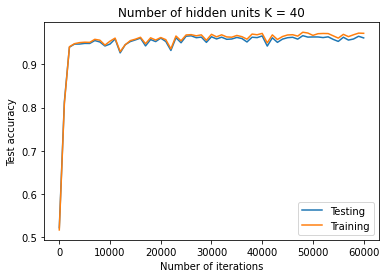

Accuracy = 96.19%


In [34]:
plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Number of hidden units K = "+str(k))
leg = plt.legend()
plt.show()
accuracy = tester_neural(test_norm,test_labels,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

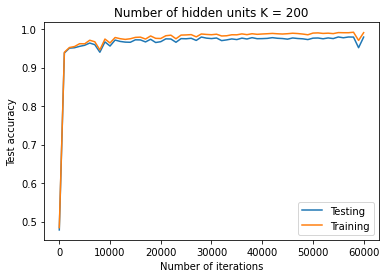

Accuracy = 97.95%


In [38]:
plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Number of hidden units K = "+str(k))
leg = plt.legend()
plt.show()
accuracy = tester_neural(test_norm,test_labels,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

## Q4 - Neural Network with Sigmoid Function and Logistic Loss

In [40]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

def forward1(x,w,v):
    l1 = w@x
    l1_func = relu(l1)
    f_x = sigmoid(l1_func@v)
    return l1, l1_func, f_x
 
#testing function
def tester_neural1(datax,datay,w,v):
    pred = []
    for x,y in zip(datax, datay):
        l1,l1_f,l2 = forward1(x,w,v)
        pred.append(l2)
        
    pred = [1 if i>0.5 else 0 for i in pred]
    c = 0
    for x,y in zip(pred, datay):
        if x==y: c+=1
    return c/len(pred)

In [49]:
# My neural network trained using SGD
k=200  # Number of hidden units
d=785  # Input dimension
n=0.3  #learning rate
b=10
itrs = 60000
#xavier initialization
w=np.random.normal(loc=0.0, scale=(1/d)**0.5, size=(k,d))# Input layer     
v=np.random.normal(loc=0.0, scale=(1/k)**0.5, size=(k,))# Output layer    
#w = np.zeros((k,d))
#v=np.zeros((k,))
iteration_counter =[]
test_acc = []
train_acc = []

for i in tqdm(range(itrs+1)):
    cur_batch = np.random.randint(0, high = 60000, size = b)     #picking random images from entire dataset
    xdata = train_norm[cur_batch]
    ydata = train_labels[cur_batch]
    gw =0
    gv =0
    for x,y in zip(xdata, ydata):
        l1,l1_f,l2 = forward1(x,w,v)
        gv+=(sigmoid(l2) - y)*l2*(1-l2)*(l1_f)
        relu_der = np.heaviside(l1,0)
        temp = v*relu_der
        gw+= (sigmoid(l2) - y)*l2*(1-l2)*(temp.reshape((k,1))@x.reshape((1,785)))
    
    #checking accuracy
    if i%1000==0:
        l = tester_neural1(test_norm, test_labels, w, v)
        test_acc.append(l)
        iteration_counter.append(i)
        l1 = tester_neural1(train_norm, train_labels, w, v)
        train_acc.append(l1)
    
    v-=(n/b)*gv
    w-=(n/b)*gw
    

100%|████████████████████████████████████| 60001/60001 [09:58<00:00, 100.29it/s]


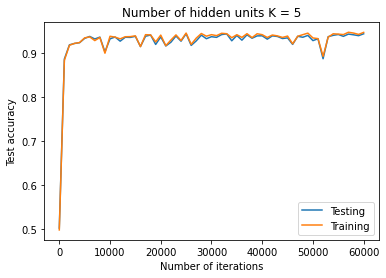

Accuracy = 94.33%


In [46]:
plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Number of hidden units K = "+str(k))
leg = plt.legend()
plt.show()
accuracy = tester_neural1(test_norm,test_labels,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

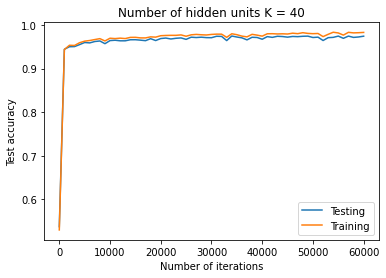

Accuracy = 97.42%


In [48]:
plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Number of hidden units K = "+str(k))
leg = plt.legend()
plt.show()
accuracy = tester_neural1(test_norm,test_labels,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")

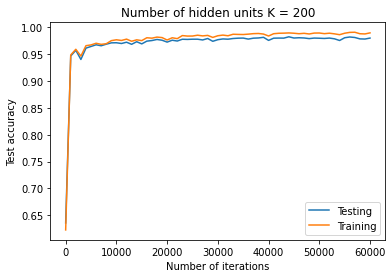

Accuracy = 97.98%


In [50]:
plt.plot(iteration_counter, test_acc, label = "Testing")
plt.plot(iteration_counter, train_acc, label = "Training")
plt.xlabel("Number of iterations")
plt.ylabel("Test accuracy")
plt.title("Number of hidden units K = "+str(k))
leg = plt.legend()
plt.show()
accuracy = tester_neural1(test_norm,test_labels,w,v)
print("Accuracy = "+str(round(accuracy*100,4))+"%")